In [116]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append("/home/cgarcia_2002/nHits_count")

import functions_nHits  # Importa la función que necesitas
import importlib

importlib.reload(functions_nHits)

<module 'functions_nHits' from '/home/cgarcia_2002/nHits_count/functions_nHits.py'>

In [117]:
Partition = "P0"
root_file_path = f"/data/cgarcia_2002/WCTE/data/WCTE_offline_R2385S0{Partition}.root"
# Open the ROOT file and get the TTree
file = uproot.open(root_file_path)
tree = file["WCTEReadoutWindows"]  

In [118]:
df_filtered = pd.read_hdf(f"/home/cgarcia_2002/nHits_count/dataFrames_nHits/Filtered_df/nHits_DataFrame_{Partition}_Prompt.h5", key="df")

events_prompt = df_filtered["event_number"].tolist()
times_prompt = df_filtered["idxmax"].tolist()

"""events_prompt = [12]
# Filter rows where event_number is in the list
filtered_df = df_filtered[df_filtered["event_number"].isin(events_prompt)]

# Extract idxmax (times_prompt) corresponding to those events
times_prompt = filtered_df["idxmax"].tolist()

print(times_prompt)"""

'events_prompt = [12]\n# Filter rows where event_number is in the list\nfiltered_df = df_filtered[df_filtered["event_number"].isin(events_prompt)]\n\n# Extract idxmax (times_prompt) corresponding to those events\ntimes_prompt = filtered_df["idxmax"].tolist()\n\nprint(times_prompt)'

In [126]:
i=0
index_delta3d=0
multiplicity = {}
Delta_t = []
nHits_df = []
Delta_t_3d = {}
events = []


width_bin = 100
up_condition_n = 50
down_condition_n = 10

for event, time in zip(events_prompt, times_prompt):
    
    print(f"analyzing event number {event}")
    nHits, times_array = functions_nHits.fun_window(tree, width_bin, event, time)
    # Paso 1: obtener los índices con nHits entre 15 y 100
    indices = np.where((nHits > down_condition_n) & (nHits < up_condition_n))[0]

    # Paso 2: obtener los tiempos correspondientes
    times_selected = times_array[indices]

    # Paso 3: aplicar condición adicional: time > 1500
    mask = times_selected > width_bin*2

    # Paso 4: filtrar tanto los índices como los tiempos
    filtered_indices = indices[mask]
    filtered_times = times_selected[mask]

    nHits_df.append(nHits)  

    if len(filtered_indices)!=0:
    
        list_delete = []
        for j in range(len(filtered_times)-1):
            if filtered_times[j+1] - filtered_times[j]<width_bin+1:
                print("Deleting index:", j, "with time", filtered_times[j], "because it is too close to", filtered_times[j+1]) 
                list_delete.append(j)

        filtered_indices = np.delete(filtered_indices, list_delete)
        filtered_times = np.delete(filtered_times, list_delete)

        if len(filtered_indices) !=0:
            multiplicity[len(filtered_indices)] = multiplicity.get(len(filtered_indices), 0) + 1
    
        Delta_t.extend(filtered_times)
        Delta_t_3d[index_delta3d] = filtered_times

        events.append(event)
        print(f"Índices > {down_condition_n} & < {up_condition_n}:", len(filtered_indices), "in time", filtered_times)
        i+=1

        """        plt.figure()
        plt.bar(times_array, nHits, width = width_bin, align='edge')
        tiempos_str = ', '.join(str(t) for t in filtered_times)
        plt.bar(filtered_times, nHits[filtered_indices], width=width_bin*4, align='edge', color='red', label=f'{tiempos_str} ns')
        plt.legend()
        plt.title(f"Event {event} - nHits vs Time")
        plt.xlabel("time (ns)")
        plt.ylabel("nHits")
        plt.show()"""


    index_delta3d += 1
print(events)
print(f"Of the total number of prompt signals {len(events_prompt)}, {i} have a possible neutron peak")

analyzing event number 8
[INFO] 2 bins removed from the beginning of the histogram for event 8
analyzing event number 12
[INFO] 10 bins removed from the beginning of the histogram for event 12
Índices > 10 & < 50: 5 in time [  400 40400 56600 79000 93800]
analyzing event number 24
We are extending to the next event the time range
[INFO] 4 bins removed from the beginning of the histogram for event 24
analyzing event number 30
[INFO] 2 bins removed from the beginning of the histogram for event 30
analyzing event number 42
We are extending to the next event the time range
[INFO] 1 bins removed from the beginning of the histogram for event 42
analyzing event number 46
[INFO] 5 bins removed from the beginning of the histogram for event 46
Índices > 10 & < 50: 2 in time [22200 95100]
analyzing event number 62
[INFO] 2 bins removed from the beginning of the histogram for event 62
analyzing event number 66
analyzing event number 69
[INFO] 13 bins removed from the beginning of the histogram for

In [111]:
print("Delta_t:", multiplicity)

Delta_t: {5: 1, 2: 11, 1: 25, 4: 1, 6: 1, 3: 2}


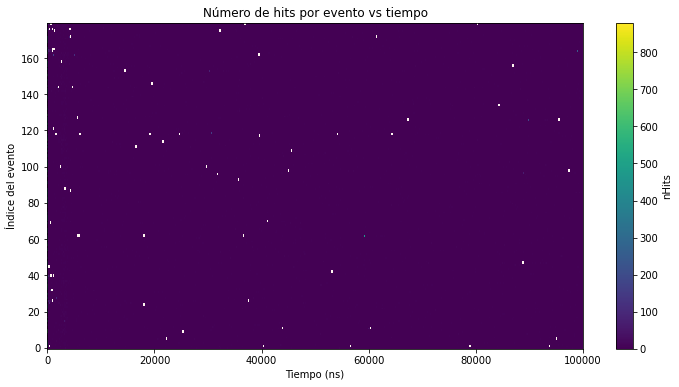

In [ ]:
# Suponiendo que nHits_df es una lista de arrays de igual longitud
z = np.vstack(nHits_df)  # shape: (num_events, num_times)

# Eje X: el array de tiempos (por ejemplo, times_array_out)
x = times_array

# Eje Y: índices de eventos
y = np.arange(z.shape[0])

# Creamos la malla de coordenadas X, Y para pcolormesh
X, Y = np.meshgrid(x, y)

plt.figure(figsize=(12, 6))
pcm = plt.pcolormesh(X, Y, z, shading='auto', cmap='viridis', edgecolors='none')

# Create a mask with NaNs everywhere
highlight_mask = np.full_like(z, np.nan, dtype=float)

# Fill with 1.0 where you want red squares (from Delta_t dict)
for y_idx, x_vals in Delta_t_3d.items():
    if np.isscalar(x_vals):
        x_vals = [x_vals]
    for t in x_vals:
        try:
            j = np.where(x == t)[0][0]  # Get x index
            highlight_mask[y_idx, j] = 1.0
        except IndexError:
            print("Time not found in x:", t)


plt.xlabel("Tiempo (ns)")
plt.ylabel("Índice del evento")
plt.title("Número de hits por evento vs tiempo")
cbar = plt.colorbar(pcm)
cbar.set_label("nHits")

# Overlay red cells (with NaN-masked values)
plt.pcolormesh(X, Y, highlight_mask, shading='auto', cmap='Reds', edgecolors='none')

#plt.tight_layout()
plt.savefig(f"nHits_vs_time_{Partition}_prompt_{width_bin}.pdf")
plt.savefig(f"nHits_vs_time_{Partition}_prompt_{width_bin}.png", facecolor='white')
plt.show()

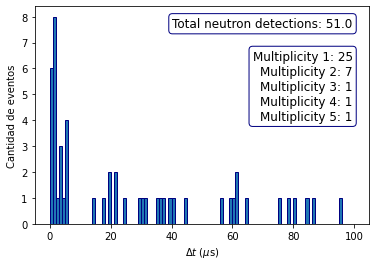

In [123]:
bin_t = 1000
DeltaT = np.arange(0, 100, 1)

histogram_DeltaT = functions_nHits.count_nHits(np.array(Delta_t), bin_t, np.zeros((len(DeltaT))))

plt.figure()
plt.bar(DeltaT, histogram_DeltaT, width=1, align = "edge", edgecolor="navy")
total = np.sum(histogram_DeltaT)

# Prepare multiplicity text lines excluding key 1
lines = []
for k, v in sorted(multiplicity.items()):
    lines.append(f"Multiplicity {k}: {v}")

# Join lines with newline character
multiplicity_text = "\n".join(lines)

# Añadir texto en el gráfico (esquina superior derecha)
plt.text(0.95, 0.95, f"Total neutron detections: {total}", transform=plt.gca().transAxes,
         ha='right', va='top', fontsize=12, bbox=dict(boxstyle="round", fc="white", ec="navy"))

# Add multiplicity text below the total, with vertical spacing
plt.text(0.95, 0.80, multiplicity_text, transform=plt.gca().transAxes,
         ha='right', va='top', fontsize=12, bbox=dict(boxstyle="round", fc="white", ec="navy"))

plt.xlabel(r"$\Delta t$ ($\mu$s)")
plt.ylabel("Cantidad de eventos")
plt.savefig("Delta_t_hist_25.pdf")
plt.show()